In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import keras
from keras import layers
from keras.layers import Activation, Dense
from keras.optimizers import RMSprop
import rbflayer, kmeans_initializer
from rbflayer import InitCentersRandom
from keras.initializers import RandomUniform, Initializer, Constant

from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Activation, Dropout
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from scipy import * 
from scipy.linalg import norm, pinv
from matplotlib import pyplot as plt  
import warnings
warnings.filterwarnings("ignore")

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICE"]  = '0'

# load data

In [3]:
Feature_A = pd.read_excel(io=r'C:\Users\Serendipity\Attention_RBF\Feature_A.xlsx')
Feature_B = pd.read_excel(io=r'C:\Users\Serendipity\Attention_RBF\Feature_B.xlsx')
Feature_C = pd.read_excel(io=r'C:\Users\Serendipity\Attention_RBF\Feature_c.xlsx')

In [4]:
Feature_A = Feature_A.rename(columns={"Isa_A": "Isa", "Isd_A": "Isd","Iar_A": "Iar","Pvd_A": "Pvd","θ_A":"θ"})
Feature_B = Feature_B.rename(columns={"Isa_B": "Isa", "Isd_B": "Isd","Iar_B": "Iar","Pvd_B": "Pvd","θ_B":"θ"})
Feature_C = Feature_C.rename(columns={"Isa_C": "Isa", "Isd_C": "Isd","Iar_C": "Iar","Pvd_C": "Pvd","θ_C":"θ"})

In [5]:
Feature = pd.concat([
    Feature_A,
    Feature_B,
    Feature_C,
]) 

In [6]:
label_y = Feature['label']
X_feat =  Feature[['负载率','Isa','三相电流不平衡度','Isd','Iar','Pvd','负载率差值','θ']]
# float64->float32
#X_feat[X_feat.select_dtypes(np.float64).columns] = X_feat.select_dtypes(np.float64).astype(np.float32)

# inf,nan数据填充
X_feat = (X_feat.replace([np.inf, -np.inf], np.nan)).fillna(value = 0) 

In [7]:
#X_feat = X_feat.drop(columns = ['三相电流不平衡度','Pvd','负载率差值'])

# SMOTE样本均衡化处理

In [8]:
from collections import Counter
# 查看所生成的样本类别分布，0和1样本比例9比1，属于类别不平衡数据
print(Counter(label_y))
# Counter({0: 900, 1: 100})

Counter({0: 149618, 1: 1834})


In [9]:
# 使用imlbearn库中上采样方法中的SMOTE接口
from imblearn.over_sampling import SMOTE
# 定义SMOTE模型，random_state相当于随机数种子的作用
smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_resample(X_feat, label_y)

In [10]:
print(Counter(y_smo))
# Counter({0: 900, 1: 100})

Counter({0: 149618, 1: 149618})


In [11]:
scaler = MinMaxScaler((0,1))

lb = LabelEncoder()

# RBF

In [12]:
import rbflayer, kmeans_initializer
rbflayer.RBFLayer

rbflayer.RBFLayer

In [13]:
X_smo

负载率        Isa  三相电流不平衡度         Isd       Iar       Pvd  \
0       14.373800   0.000000  0.221106    0.000000  0.128571  0.000222   
1       12.714300  -7.931262  0.372881   -6.172840  0.128571  0.000222   
2       13.942100 -14.276272  0.316327  -10.465116  0.136508  0.000270   
3       15.796000  38.070059  0.295455   25.263158  0.150794  0.000413   
4       12.479500   3.172505  0.231214    2.816901  0.112698  0.000032   
...           ...        ...       ...         ...       ...       ...   
299231  16.318183 -22.278998  0.251495  -20.864044  0.146751  0.000391   
299232   5.064354 -84.854526  0.279909 -151.887609  0.036940  0.000578   
299233  19.471195 -23.951392  0.386530  -17.749873  0.091627  0.000229   
299234  18.119446 -50.202186  0.568227 -132.136228  0.076000  0.001348   
299235  24.059451  11.087138  0.079039   10.255191  0.172603  0.000179   

            负载率差值         θ  
0       -1.659500  0.006229  
1        1.227800 -0.078344  
2        1.853900 -0.140728  
3       -3.316500  0.353894  
4       -0.261900  0.034775  
...           ...       ...  
299231   1.918612 -0.218812  
299232   2.766760 -0.700622  
299233   1.796548 -0.233068  
299234  14.167156 -0.457158  
299235  -1.565689  0.108278  

[299236 rows x 8 columns]

In [14]:
X_smo[['负载率']] = scaler.fit_transform(X_smo[['负载率']])
X_smo[['Isa']] = scaler.fit_transform(X_smo[['Isa']])
X_smo[['三相电流不平衡度']] = scaler.fit_transform(X_smo[['三相电流不平衡度']])
X_smo[['Isd']] = scaler.fit_transform(X_smo[['Isd']])
X_smo[['Iar']] = scaler.fit_transform(X_smo[['Iar']])
X_smo[['Pvd']] = scaler.fit_transform(X_smo[['Pvd']])
X_smo[['负载率差值']] = scaler.fit_transform(X_smo[['负载率差值']])
X_smo[['θ']] = scaler.fit_transform(X_smo[['θ']])

In [27]:
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    print("epoch({}) lr is {}".format(epoch, K.get_value(model.optimizer.lr)))
    return K.get_value(model.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)

In [28]:
X_smo = X_smo.rename(columns={'Iar':'I_CAR','Isd':'I_DD','Isa':'I_CD','三相电流不平衡度':'ε','负载率':'η','负载率差值':'Δη'})

In [29]:
X_smo

η      I_CD         ε      I_DD     I_CAR       Pvd        Δη  \
0       0.221826  0.377639  0.229545  0.809091  0.193614  0.041000  0.607745   
1       0.195215  0.355547  0.387113  0.797306  0.193614  0.041000  0.641269   
2       0.214903  0.337874  0.328400  0.789112  0.206852  0.049786  0.648539   
3       0.244632  0.483680  0.306731  0.857321  0.230682  0.076144  0.588506   
4       0.191450  0.386476  0.240039  0.814469  0.167137  0.005857  0.623972   
...          ...       ...       ...       ...       ...       ...       ...   
299231  0.253005  0.315583  0.261094  0.769260  0.223938  0.072104  0.649290   
299232  0.072544  0.141283  0.290592  0.519124  0.040767  0.106734  0.659138   
299233  0.303565  0.310924  0.401283  0.775205  0.131988  0.042293  0.647873   
299234  0.281889  0.237805  0.589915  0.556831  0.105922  0.248795  0.791507   
299235  0.377141  0.408521  0.082056  0.828669  0.267061  0.032934  0.608834   

               θ  
0       0.449594  
1       0.408980  
2       0.379023  
3       0.616546  
4       0.463301  
...          ...  
299231  0.341526  
299232  0.110156  
299233  0.334681  
299234  0.227070  
299235  0.498599  

[299236 rows x 8 columns]

In [30]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_smo,y_smo,test_size=0.3)

In [31]:
# pip install keras
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 4), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [32]:
# It is the official metric used in this competition
# below is the declaration of a function used inside the keras model, calculation with K (keras backend / thensorflow)
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [33]:
history_rbf = []
dr = 0.5

RBF = rbflayer.RBFLayer(5,
                      initializer=kmeans_initializer.InitCentersKMeans(x_train),
                      #initializer=InitCentersRandom(X_smo),
                      betas=5.0,
                      input_shape=([8]))

model = keras.models.Sequential()
model.add(RBF)

# model.add(layers.Dense(128,activation='selu',name='fc1'))
# model.add(Dropout(dr))
# model.add(layers.Dense(128,activation='selu',name='fc2'))
# model.add(Dropout(dr))
model.add(layers.Dense(1,activation = 'sigmoid'))

model.compile(optimizer=RMSprop(),loss ='binary_crossentropy', metrics=['acc'])

filepath = 'weights/RBF_dr0.5.h5'
history = model.fit(x_train, y_train,
                   epochs = 100,
                   batch_size = 1024,
                   validation_data = (x_test,y_test),
                   callbacks = [reduce_lr, 
                                keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                                keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,verbose=1,patince=3,min_lr=0.000001)
            #keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
                               ]
                   )

history_rbf.append(history)

Train on 209465 samples, validate on 89771 samples
epoch(0) lr is 0.0010000000474974513
Epoch 1/100
204800/209465 [============================>.] - ETA: 0s - loss: 0.6671 - acc: 0.6117WARNING:tensorflow:From D:\Anaconda3\envs\AMC\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_loss improved from inf to 0.62683, saving model to weights\RBF_dr0.5.h5
209465/209465 [==============================] - 1s 3us/sample - loss: 0.6663 - acc: 0.6130 - val_loss: 0.6268 - val_acc: 0.6705
epoch(1) lr is 0.0010000000474974513
Epoch 2/100
198656/209465 [===========================>..] - ETA: 0s - loss: 0.6161 - acc: 0.6761
Epoch 00002: val_loss improved from 0.62683 to 0.60745, saving model to weights\RBF_dr0.5.h5
209465/209465

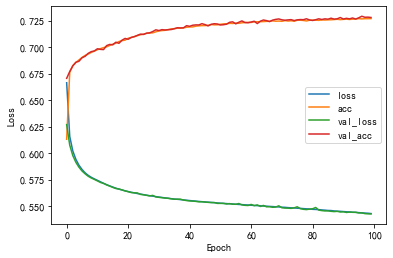

In [34]:
import matplotlib as mpl
plt.rcParams['font.sans-serif']=['SimHei'] #图中文字体设置为黑体
mpl.rcParams['font.serif'] = ['KaiTi']
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题,或者转换负号为字符串

plot = pd.DataFrame(history_rbf[0].history).drop(columns = ['lr']).plot()

#fig, ax = plt.subplots(figsize=(12,12))
fig = plot.get_figure()

# 设置图例字体大小
#ax.legend(..., fontsize=20)
#xgb.plot_importance(clf1, height=0.4, ax=ax)
#ax.set_title('特征重要性排序',fontsize= 20) 
plot.set_xlabel('Epoch', fontsize=10)
plot.set_ylabel('Loss', fontsize=10)
fig.savefig("loss.png",dpi=300)
#plt.show()



In [35]:
y_pred = model.predict(x_test)

In [36]:
y_pred = y_pred.reshape(89771,)

In [37]:
def argmax(y_pred):
    for i in range(y_pred.shape[0]):
        if(y_pred[i]<0.5):
            y_pred[i] = 0
        else:
            y_pred[i] = 1
    return y_pred

In [38]:
y_pred = argmax(y_pred)

In [39]:
print(Counter(y_pred))

Counter({0.0: 47687, 1.0: 42084})


In [40]:
# Calculate metrics
from sklearn.metrics import accuracy_score
from sklearn import datasets,model_selection,metrics,tree,preprocessing
acc = accuracy_score(y_test,y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test,y_pred,average='binary')

recall = metrics.recall_score(y_test,y_pred, average='macro')

fscore = metrics.f1_score(y_test,y_pred, average='weighted')

In [41]:
acc,precision,recall,fscore

(0.7278631183789865,
 0.7405189620758483,
 0.7277211265216139,
 0.7275993008328551)

# XGBoost

In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import sklearn
import warnings
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import  pyplot
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt

In [22]:
clf1 = xgb.XGBClassifier(max_depth=6,
                        learning_rate=0.05,
                        n_estimators=2000,
                        objective='reg:logistic',
                        gamma=0.0,
                        min_child_weight=1,
                        max_delta_step=0,
                       subsample=1,
                        colsample_bytree=0.8,
                        colsample_bylevel=1,
                        reg_alpha=0,
                        reg_lambda=1,
                        scale_pos_weight=1,
                        silent=1
                        )
clf1.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], eval_metric='logloss',verbose = False)
############################################################

[01:01:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# plot_importance

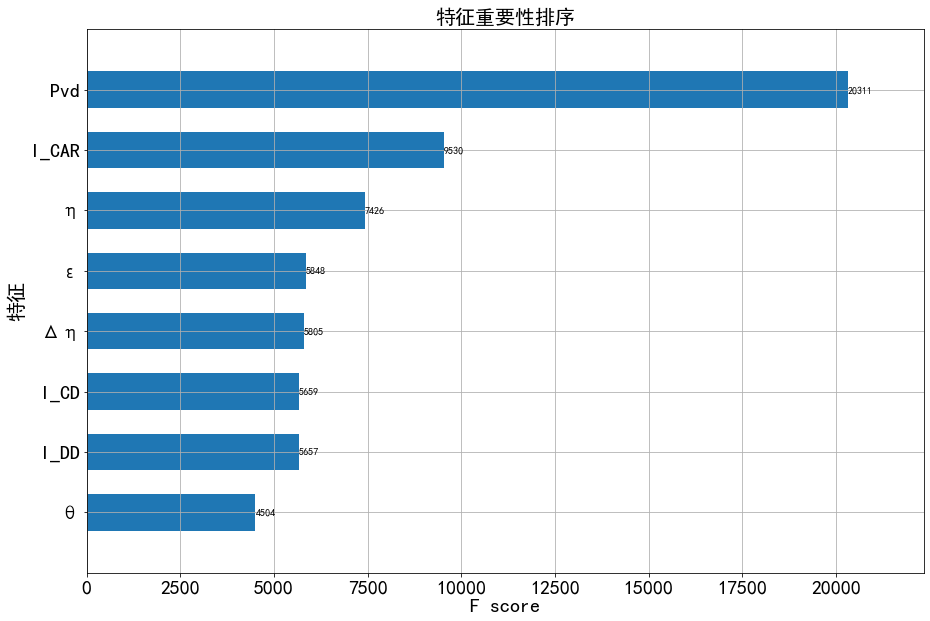

In [26]:
from xgboost import XGBClassifier
from xgboost import plot_importance
#mpl.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['font.sans-serif']=['SimHei'] #图中文字体设置为黑体
mpl.rcParams['font.serif'] = ['KaiTi']
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题,或者转换负号为字符串

fig, ax = plt.subplots(figsize=(15,10))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# 设置图例字体大小
#ax.legend(..., fontsize=20)
xgb.plot_importance(clf1, height=0.6, ax=ax)
ax.set_title('特征重要性排序',fontsize= 20) 
ax.set_xlabel('F score', fontsize=20)
ax.set_ylabel('特征', fontsize=20)
plt.savefig('feature_importance.png',dpi=300)
plt.show()

In [151]:
y_pred = clf1.predict_proba(x_test)[:, 1]

In [152]:
y_pred = argmax(y_pred)

In [153]:
print(Counter(y_pred))
# Counter({0: 900, 1: 100})

Counter({0.0: 45020, 1.0: 44751})


In [154]:
# Calculate metrics
from sklearn.metrics import accuracy_score
from sklearn import datasets,model_selection,metrics,tree,preprocessing
acc = accuracy_score(y_test,y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test,y_pred,average='binary')

recall = metrics.recall_score(y_test,y_pred, average='macro')

fscore = metrics.f1_score(y_test,y_pred, average='weighted')

In [155]:
acc,precision,recall,fscore

(0.9889496608036003,
 0.9911733816004111,
 0.9889530196857934,
 0.9889496422456546)

# Att_RBF

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer (RBFLayer)         (None, 5)                 45        
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [44]:
rbf_layer_model = keras.Model(inputs=model.input,outputs=model.get_layer('rbf_layer').output)

In [45]:
rbf_layer_output = rbf_layer_model.predict(x_train)

In [46]:
rbf_layer_output.shape

(209465, 5)

In [47]:
import keras.backend as K
import numpy as np
 
 
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
#from attention_utils import get_activations, get_data
 
np.random.seed(1337)  # for reproducibility
 
from keras.models import *
from keras.layers import Input, Dense,Multiply,Activation
 
input_dim = 5
 
 
 
def Att(att_dim,inputs,name):
    V = inputs
    QK = Dense(att_dim,use_bias=None)(inputs)
    QK = Activation("softmax",name=name)(QK)
    MV = Multiply()([V, QK])
    return(MV)

In [49]:
def build_model():
    
    inputs = Input(shape=(input_dim,))
    #print(rbf)
    
    atts1 = Att(input_dim,inputs,"rbf_layer_att")
    
    x = Dense(16)(atts1)
    atts2 = Att(16,x,"attention_vec1")
 
 
    output = Dense(1, activation='sigmoid')(atts2)
    model = Model(inputs=inputs, outputs=output)
    
    return model

In [50]:
rbf_layer_output = rbf_layer_model.predict(x_train)
inputs_1 = rbf_layer_output
outputs = y_train.values.reshape(x_train.shape[0],1)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 5)            25          input_1[0][0]                    
__________________________________________________________________________________________________
rbf_layer_att (Activation)      (None, 5)            0           dense_1[0][0]                    
__________________________________________________________________________________________________
multiply (Multiply)             (None, 5)            0           input_1[0][0]                    
                                                                 rbf_layer_att[0][0]   

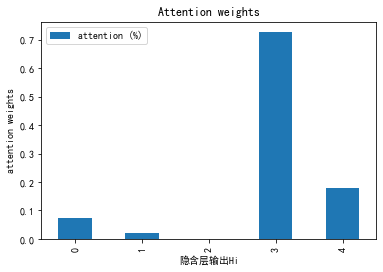

In [51]:
m = build_model()

m.compile(optimizer='adam', loss='binary_crossentropy', metrics=[matthews_correlation])
print(m.summary())

#m.fit(inputs_1, outputs, epochs=100, batch_size=128, validation_split=0.2)

history_att = []
history = m.fit(inputs_1, outputs,
                   epochs = 100,
                   batch_size = 128,
                   validation_split=0.2,
                   callbacks = [reduce_lr, 
                                keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                                keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,verbose=1,patince=3,min_lr=0.000001)
            #keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
                               ]
                   )

history_att.append(history)




testing_inputs_1, testing_outputs = get_data(1, input_dim)

# Attention vector corresponds to the second matrix.
# The first one is the Inputs output.
attention_vector = get_activations(m, testing_inputs_1,
                                   print_shape_only=True,
                                   layer_name='rbf_layer_att')[0].flatten()

print('attention =', attention_vector)


# plot part.


plot = pd.DataFrame(attention_vector, columns=['attention (%)']).plot(kind='bar',
                                                               title='Attention weights')
fig = plot.get_figure()

plot.set_xlabel('隐含层输出Hi', fontsize=10)
plot.set_ylabel('attention weights', fontsize=10)


fig.savefig("Attention.png",dpi=300)
plt.show()


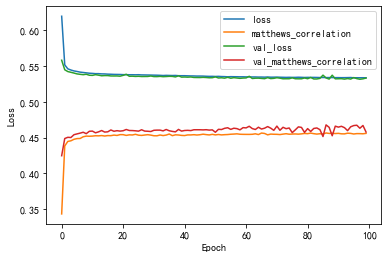

In [53]:
import matplotlib as mpl
plt.rcParams['font.sans-serif']=['SimHei'] #图中文字体设置为黑体
mpl.rcParams['font.serif'] = ['KaiTi']
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题,或者转换负号为字符串

plot = pd.DataFrame(history_att[0].history).drop(columns = ['lr']).plot()

#fig, ax = plt.subplots(figsize=(12,12))
fig = plot.get_figure()

# 设置图例字体大小
#ax.legend(..., fontsize=20)
#xgb.plot_importance(clf1, height=0.4, ax=ax)
#ax.set_title('特征重要性排序',fontsize= 20) 
plot.set_xlabel('Epoch', fontsize=10)
plot.set_ylabel('Loss', fontsize=10)
fig.savefig("loss.png",dpi=300)
#plt.show()

In [54]:
rbf_layer_output = rbf_layer_model.predict(x_test)
#inputs_1 = rbf_layer_output
#outputs = y_test.values.reshape(x_test.shape[0],1)
y_pred = argmax(m.predict(rbf_layer_model.predict(x_test)))

In [55]:
# Calculate metrics
from sklearn.metrics import accuracy_score
from sklearn import datasets,model_selection,metrics,tree,preprocessing
acc = accuracy_score(y_test,y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test,y_pred,average='binary')

recall = metrics.recall_score(y_test,y_pred, average='macro')

fscore = metrics.f1_score(y_test,y_pred, average='weighted')

In [56]:
acc,precision,recall,fscore

(0.728475788394916, 0.721745209849031, 0.7285273413551869, 0.7284508753138446)

# CART

In [176]:
from sklearn import datasets,model_selection,metrics,tree,preprocessing
#x=preprocessing.StandardScaler().fit_transform(x)
# 划分训练集、测试集
x_train,x_test,y_train,y_test=model_selection.train_test_split(X_smo,y_smo,test_size=0.3)
# 导入决策树
model1=tree.DecisionTreeClassifier(max_depth=40)
# 模型训练
model1.fit(x_train,y_train)
# 模型预测
y_pred=model1.predict(x_test)
# 模型性能评价
print(metrics.accuracy_score(y_pred,y_test))

0.9479564670105045


In [177]:
# 网络搜索最佳深度
parameters={'max_depth':[10,20,25,30]}
model2=tree.DecisionTreeClassifier()
cvModel=model_selection.GridSearchCV(model2,parameters,cv=5)
cvModel.fit(x_train,y_train)
print(cvModel.best_score_)
print(cvModel.best_params_)

0.94242474876471
{'max_depth': 30}


In [178]:
# Calculate metrics
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test,y_pred,average='binary')

recall = metrics.recall_score(y_test,y_pred, average='macro')

fscore = metrics.f1_score(y_test,y_pred, average='weighted')

In [179]:
acc,precision,recall,fscore

(0.9479564670105045, 0.9391067538126362, 0.947934241285034, 0.9479498795517582)

In [235]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(model1, out_file=None, 
                     feature_names=['负载率','Isa','三相电流不平衡度','Isd','Iar','Pvd','负载率差值'],  
                     class_names=['0','1'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph